In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from huggingface_hub import HfFileSystem
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, prepare_model_for_kbit_training
from trl import SFTTrainer, SFTConfig
from datasets import Dataset, concatenate_datasets, load_dataset
from tqdm import tqdm
from tqdm.notebook import tqdm


import pandas as pd
import psutil
import json
import torch
import ast
import os
import re
from datetime import datetime
import requests
from dotenv import load_dotenv

load_dotenv()

WANDB_API_KEY = os.getenv("WANDB_API_KEY")
HF_TOKEN      = os.getenv("HF_TOKEN")

# AUTH
# from huggingface_hub import login
# import wandb
# login(token=HF_TOKEN)
# wandb.login(key=WANDB_API_KEY)


## Initial Configuration and Helper Function Corpus

In [ ]:
PRETRAIN_RATIO = 10 # 10% of training data from DCLM
WANDB_PROJECT  = "ActiveReading"
smoke_test = False
# Active Reading limit for chunk files, None for all chunks
AR_CHUNK_FILES_LIMIT = 5

# SimpleQA CSV — downloaded at runtime to extract target Wikipedia titles
SIMPLEQA_CSV_URL  = "https://openaipublic.blob.core.windows.net/simple-evals/simple_qa_test_set.csv"
SIMPLEQA_CSV_PATH = "./simple_qa_test_set.csv"   # cached locally after first download


In [ ]:
def download_simpleqa_csv():
    if os.path.exists(SIMPLEQA_CSV_PATH):
        print(f"Using cached SimpleQA CSV: {SIMPLEQA_CSV_PATH}")
        return
    print(f"Downloading SimpleQA CSV from {SIMPLEQA_CSV_URL} ...")
    r = requests.get(SIMPLEQA_CSV_URL, timeout=60)
    r.raise_for_status()
    with open(SIMPLEQA_CSV_PATH, "wb") as f:
        f.write(r.content)
    print(f"  Saved to {SIMPLEQA_CSV_PATH}")

def extract_target_titles():
    """
    Parse SimpleQA CSV and return the set of Wikipedia article titles
    referenced by at least one question (the SimpleWikiQA subset).
    Title is extracted from the en.wikipedia.org/wiki/<Title> URL pattern.
    """
    df = pd.read_csv(SIMPLEQA_CSV_PATH)
    print(f"Total SimpleQA questions: {len(df)}")

    titles = set()
    for _, row in df.iterrows():
        try:
            meta = ast.literal_eval(row["metadata"])
        except Exception:
            continue
        for url in meta.get("urls", []):
            m = re.search(r"en\.wikipedia\.org/wiki/(.+?)(?:\?|#|$)", url)
            if m:
                title = requests.utils.unquote(m.group(1)).replace("_", " ")
                titles.add(title)

    print(f"Unique Wikipedia article titles in SimpleWikiQA: {len(titles)}")
    return titles

In [ ]:
def format_ar_example(row):
    """
    Convert one row from facebook/meta-active-reading into a plain-text
    training string.
    """
    messages = row["request"]["messages"]
    response = row["response"]["text"]

    prompt_parts = []
    for msg in messages:
        role = msg['role'].upper()
        content = msg['content']
        prompt_parts.append(f"### {role}\n{content}")

    prompt = "\n\n".join(prompt_parts)
    full_text = f"{prompt}\n\n### ASSISTANT\n{response}"
    return {"text": full_text}


def load_ar_dataset(target_titles):
    """
    Stream facebook/meta-active-reading chunk files, keep only rows whose
    metadata["title"] is in target_titles, format each row, return a Dataset.
    """
    print("\nScanning facebook/meta-active-reading chunk files ...")
    fs    = HfFileSystem()
    files = fs.glob("datasets/facebook/meta-active-reading/chunk.*.jsonl")
    print(f"  Total chunk files available: {len(files)}")

    if AR_CHUNK_FILES_LIMIT:
        files = files[:AR_CHUNK_FILES_LIMIT]
        print(f"  Limited to first {AR_CHUNK_FILES_LIMIT} chunk files for this run")

    ds = load_dataset(
        "json",
        data_files={"train": [f"hf://{f}" for f in files]},
        split="train",
    )
    print(f"  Rows loaded before filter: {len(ds)}")

    ds_filtered = ds.filter(
        lambda x: x["metadata"]["title"] in target_titles,
        desc="Filtering to SimpleWikiQA titles",
    )
    print(f"Found {len(ds_filtered)} rows across {len(files)} chunks")

    return ds_filtered

def build_pretrain_mix(n_target):
    """
    Stream n_target examples from mlfoundations/dclm-baseline-1.0.

    DCLM is a large web-crawl corpus with no domain structure — we take the
    first n_target rows with no title filtering. mix in 10% of pre-training data from DCLM
    """
    if n_target <= 0:
        return Dataset.from_dict({"text": []})

    print(f"\nLoading {n_target} DCLM pre-training examples ...")
    ds = load_dataset(
        "mlfoundations/dclm-baseline-1.0",
        split="train",
        streaming=True,
    )

    examples = []
    for row in tqdm(ds, total=n_target, desc="Loading DCLM examples"):
        text = row.get("text", "").strip()
        if len(text) > 200:
            examples.append({"text": text[:3000]})
        if len(examples) >= n_target:
            break

    print(f"  Loaded {len(examples)} DCLM pre-training examples")
    return Dataset.from_list(examples)

## Prepare Dataset loading and Pre-training Mix with DCLM data

In [5]:
# Extract target Wikipedia titles from SimpleQA
download_simpleqa_csv()
target_titles = extract_target_titles()

# Load Active Reading synthetic data filtered to those titles
ds_formatted = load_ar_dataset(target_titles)

ar_dataset = ds_formatted.map(
        format_ar_example,
        remove_columns=ds_formatted.column_names,
        desc="Formatting AR examples",
)

print(f"  Formatted training examples: {len(ar_dataset)}")

if smoke_test:
    ar_dataset = ar_dataset.shuffle(seed=42).select(range(min(20, len(ar_dataset))))
    print(f"Smoke test: using {len(ar_dataset)} AR examples")

Using cached SimpleQA CSV: ./simple_qa_test_set.csv
Total SimpleQA questions: 4326
Unique Wikipedia article titles in SimpleWikiQA: 2848

Scanning facebook/meta-active-reading chunk files ...
  Total chunk files available: 3750
  Limited to first 5 chunk files for this run


Loading dataset shards:   0%|          | 0/29 [00:00<?, ?it/s]

  Rows loaded before filter: 3735301
Found 13105 rows across 5 chunks
  Formatted training examples: 13105


In [6]:
# DCLM pre-training mix (10%)
N_PRETRAIN = max(1, len(ar_dataset) // PRETRAIN_RATIO)
pretrain_ds = build_pretrain_mix(0 if smoke_test else N_PRETRAIN)

# Combine and shuffle
mixed_ds = concatenate_datasets([ar_dataset, pretrain_ds]).shuffle(seed=42)
print(f"\nTotal training examples: {len(mixed_ds)} "
      f"({len(ar_dataset)} AR + {len(pretrain_ds)} DCLM pretrain)")



Loading 1310 DCLM pre-training examples ...


Resolving data files:   0%|          | 0/27838 [00:00<?, ?it/s]

Loading DCLM examples:   0%|          | 0/1310 [00:00<?, ?it/s]

  Loaded 1310 DCLM pre-training examples

Total training examples: 14415 (13105 AR + 1310 DCLM pretrain)


## Dataset Understanding: View All Strategies for tailored learning 

In [7]:
# Preview a small sample of the formatted training data
for i in range(1):
    print(f"\n=== Example {i+1} ===")
    print(mixed_ds[i]['text'] + "...")


=== Example 1 ===
### SYSTEM
You are a helpful assistant.

### USER
Here's a learning strategy:
 **5. Summarize the Document**
Summarize the main points of the document in your own words, this will help you to understand the information and retain it better.



Apply this strategy to the following document:
<document>

Disney Experiences
With a need for the [[Disneyland Hotel (California)|Disneyland Hotel]] nearby and no funding available for Disney to build it, Walt Disney approached [[Jack Wrather]] to build the hotel who agreed.&lt;ref&gt;&lt;/ref&gt;[[Disneyland]], changed from Disneylandia, was announced in {{dts|1954|4}} by Walt to be opened in {{dts|1955|7}}.&lt;ref group=CDL&gt;Walt Disney, by Jim Fanning, 1994. Page 100.&lt;/ref&gt;&lt;ref group=CDL&gt;Walt Disney – Hollywood's Dark Prince, by Marc Eliot, 1993. Page 223.&lt;/ref&gt; On {{dts|1955|7|17}}, the Disneyland park opened with five themed &quot;lands&quot; containing eighteen attractions with double the expected gues

In [8]:
print(ds_formatted.features)
print(ds_formatted['metadata'][0])

{'request': {'messages': List({'role': Value('string'), 'content': Value('string')})}, 'metadata': {'wiki_doc_id': Value('string'), 'title': Value('string'), 'doc_index': Value('int64'), 'chunk_index': Value('int64'), 'total_chunks': Value('int64'), 'rep': Value('int64'), 'strategy': Value('int64')}, 'response': {'text': Value('string')}, 'stats': {'prompt_length_toks': Value('int64'), 'prompt_length_chars': Value('int64'), 'completion_length_toks': Value('int64'), 'completion_length_chars': Value('int64')}}
{'wiki_doc_id': '66158911', 'title': '1985 St. Louis mayoral election', 'doc_index': 13, 'chunk_index': 0, 'total_chunks': 3, 'rep': 0, 'strategy': 0}


In [9]:
# The dataset should include about 3,083 different Wikipedia documents (wiki_doc_id/title).
# The repeat count generation is done around 10 times, and the different prompting strategies are around 60 distinct identifiers.
df = ds_formatted.to_pandas()

# Unique values in each metadata dimension
print("Unique strategies:", sorted(df['metadata'].apply(lambda x: x['strategy']).unique())) # 60 distinct strategies
print("Unique reps:", sorted(df['metadata'].apply(lambda x: x['rep']).unique())) # 10 distinct reps (0-9)
print("Unique chunk_indexes:", sorted(df['metadata'].apply(lambda x: x['chunk_index']).unique())) # up to 70 chunk positions (0-69)
print("Total rows:", len(df))

# Summary: rows per (chunk, strategy, rep)
print("\nRows per article:")
print(df.groupby(df['metadata'].apply(lambda x: x['title'])).size())

Unique strategies: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(21), np.int64(24), np.int64(27), np.int64(30)]
Unique reps: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
Unique chunk_indexes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int6

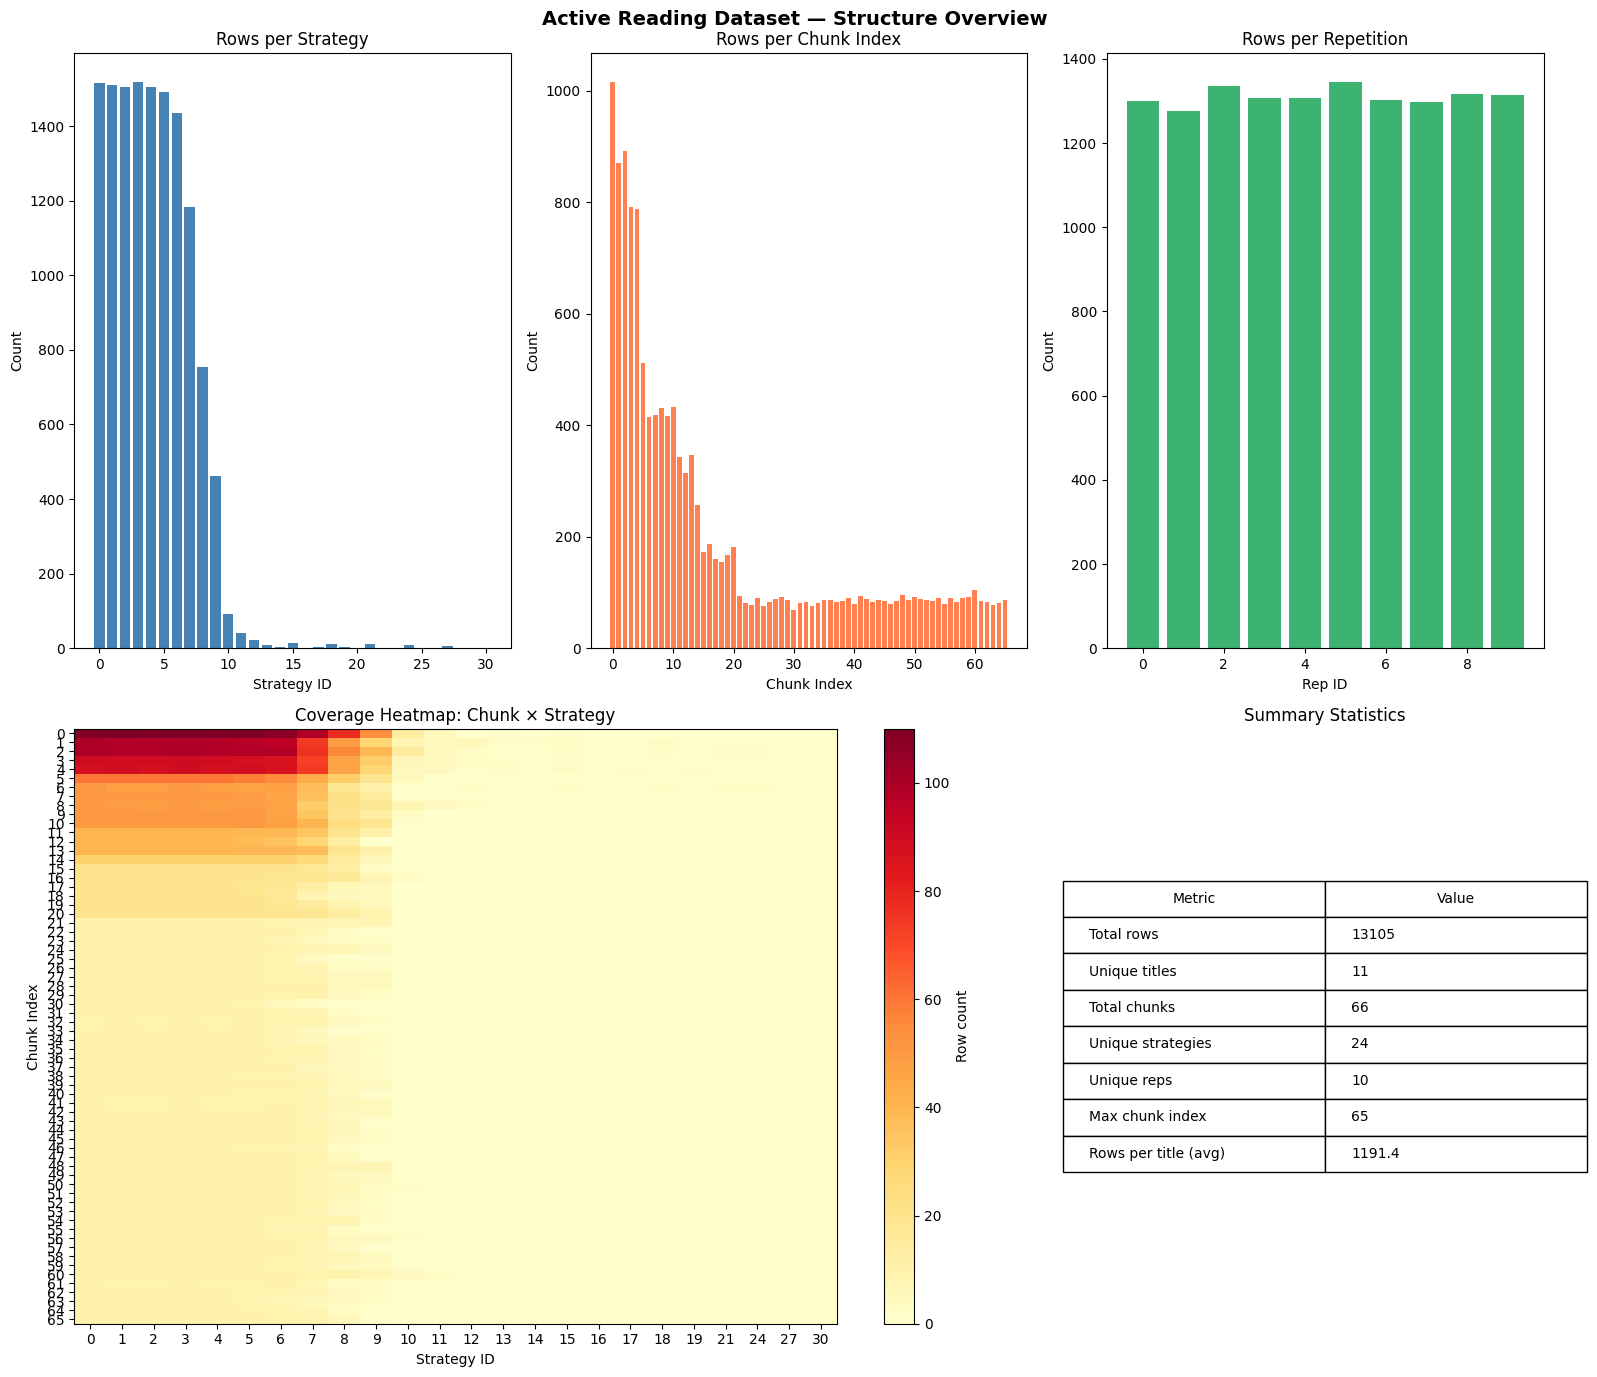

In [10]:
meta_df = pd.json_normalize(df['metadata'])
df_ = pd.concat([df.drop(columns=['metadata']), meta_df], axis=1)

fig = plt.figure(figsize=(16, 14))
gs = gridspec.GridSpec(2, 3, figure=fig)

# 1. Rows per strategy
ax1 = fig.add_subplot(gs[0, 0])
strategy_counts = df_['strategy'].value_counts().sort_index()
ax1.bar(strategy_counts.index, strategy_counts.values, color='steelblue')
ax1.set_title('Rows per Strategy')
ax1.set_xlabel('Strategy ID')
ax1.set_ylabel('Count')

# 2. Rows per chunk_index (how data is distributed across chunks)
ax2 = fig.add_subplot(gs[0, 1])
chunk_counts = df_['chunk_index'].value_counts().sort_index()
ax2.bar(chunk_counts.index, chunk_counts.values, color='coral')
ax2.set_title('Rows per Chunk Index')
ax2.set_xlabel('Chunk Index')
ax2.set_ylabel('Count')

# 3. Rows per rep
ax3 = fig.add_subplot(gs[0, 2])
rep_counts = df_['rep'].value_counts().sort_index()
ax3.bar(rep_counts.index, rep_counts.values, color='mediumseagreen')
ax3.set_title('Rows per Repetition')
ax3.set_xlabel('Rep ID')
ax3.set_ylabel('Count')

# 4. Heatmap: chunk_index vs strategy
ax4 = fig.add_subplot(gs[1, :2])
pivot = df_.groupby(['chunk_index', 'strategy']).size().unstack(fill_value=0)
im = ax4.imshow(pivot.values, aspect='auto', cmap='YlOrRd')
ax4.set_title('Coverage Heatmap: Chunk × Strategy')
ax4.set_xlabel('Strategy ID')
ax4.set_ylabel('Chunk Index')
ax4.set_xticks(range(len(pivot.columns)))
ax4.set_xticklabels(pivot.columns)
ax4.set_yticks(range(len(pivot.index)))
ax4.set_yticklabels(pivot.index)
plt.colorbar(im, ax=ax4, label='Row count')

# 5. Summary stats table
ax5 = fig.add_subplot(gs[1, 2])
ax5.axis('off')
summary = [
    ['Total rows', len(df_)],
    ['Unique titles', df_['title'].nunique()],
    ['Total chunks', df_['chunk_index'].nunique()],
    ['Unique strategies', df_['strategy'].nunique()],
    ['Unique reps', df_['rep'].nunique()],
    ['Max chunk index', df_['chunk_index'].max()],
    ['Rows per title (avg)', round(len(df_) / df_['title'].nunique(), 1)],
]
table = ax5.table(cellText=summary, colLabels=['Metric', 'Value'],
                  loc='center', cellLoc='left')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.8)
ax5.set_title('Summary Statistics')

plt.suptitle('Active Reading Dataset — Structure Overview', fontsize=14, fontweight='bold')
plt.tight_layout()
# plt.savefig('active_reading_overview.png', dpi=150, bbox_inches='tight')
plt.show()

In [11]:
strategy_templates = {}

for strategy_id in sorted(df_['strategy'].unique()):
    row = df_[df_['strategy'] == strategy_id].iloc[0]
    messages = row['request']['messages']
    
    # Extract each message role and content
    conversation = []
    for msg in messages:
        if msg['role'] == 'user':
            conversation.append({
                "content": msg['content']
            })
    
    strategy_templates[f"strategy_{strategy_id}"] = {
        "strategy_id": int(strategy_id),
        "messages": conversation
    }

# Save to JSON
with open("strategy_templates.json", "w") as f:
    json.dump(strategy_templates, f, indent=2)

print(f"Saved {len(strategy_templates)} strategy templates")

Saved 24 strategy templates


## Train the chosen LLama Model

In [12]:

# For scaling to large corpora: use lr=3e-4 (pre-training scale)

# Expert Domain Setting
BASE_MODEL    = "meta-llama/Llama-3.2-1B"
LEARNING_RATE = 1e-5
MAX_STEPS     = 5 if smoke_test else 5000
LORA_R        = 16
LORA_ALPHA    = 32
LORA_DROPOUT  = 0.05
WARMUP_RATIO  = 0.03
WARMUP_STEPS = max(1, int(MAX_STEPS * WARMUP_RATIO))
GRADIENT_CHECKPOINTING = True
RESUME_FROM_CHECKPOINT = False

In [13]:
print("=== GPU Info ===")
print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"VRAM total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
print(f"VRAM available: {torch.cuda.mem_get_info()[0] / 1e9:.1f} GB")

print("\n=== CPU Info ===")
print(f"CPU cores: {psutil.cpu_count(logical=False)} physical, {psutil.cpu_count(logical=True)} logical")
print(f"RAM total: {psutil.virtual_memory().total / 1e9:.1f} GB")
print(f"RAM available: {psutil.virtual_memory().available / 1e9:.1f} GB")

device="local" # or "colab" if running in Google Colab
if device == "local":
    # RTX 3060: 12 GB VRAM, no bfloat16, limited batch
    PER_DEVICE_BATCH   = 2
    GRAD_ACCUM         = 8
    MAX_SEQ_LEN        = 512
    FP16               = False   
    BF16               = False   
    COMPUTE_DTYPE      = torch.float16
    SAVE_STEPS         = 500
    LOGGING_STEPS      = 25
else:
    # Cloud A100/H100
    PER_DEVICE_BATCH   = 8
    GRAD_ACCUM         = 16      # effective batch = 128
    MAX_SEQ_LEN        = 1024    # paper used 4096
    FP16               = False
    BF16               = True    # A100/H100 native bfloat16
    COMPUTE_DTYPE      = torch.bfloat16
    SAVE_STEPS         = 500
    LOGGING_STEPS      = 25

=== GPU Info ===
GPU: NVIDIA GeForce RTX 3060
VRAM total: 12.9 GB
VRAM available: 11.8 GB

=== CPU Info ===
CPU cores: 12 physical, 24 logical
RAM total: 34.3 GB
RAM available: 10.3 GB


In [14]:
# Tokenizer setup
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'right'

# Load model in 4-bit QLoRA configuration for memory efficiency
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=COMPUTE_DTYPE,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_storage=COMPUTE_DTYPE
)

model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=bnb_config,
    device_map='auto',
    token=HF_TOKEN
)
model.config.use_cache = False  # required for gradient checkpointing

model = prepare_model_for_kbit_training(model)
# Cast all non-quantized layers explicitly to float16
for name, param in model.named_parameters():
    if param.dtype == torch.bfloat16:
        param.data = param.data.to(torch.float16)

vram_used = torch.cuda.memory_allocated() / 1e9
vram_total = torch.cuda.get_device_properties(0).total_memory / 1e9
print(f"  VRAM after model load: {vram_used:.1f} / {vram_total:.1f} GB")

Loading weights:   0%|          | 0/146 [00:00<?, ?it/s]

  VRAM after model load: 1.6 / 12.9 GB


In [15]:
# LoRA config
lora_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    target_modules=['q_proj', 'v_proj', 'k_proj', 'o_proj'],
    lora_dropout=LORA_DROPOUT,
    bias='none',
    task_type='CAUSAL_LM'
)

OUTPUT_DIR = f'./active-reading-llama-1b-{datetime.now().strftime("%Y%m%d-%H%M")}'
# Training config
training_args = SFTConfig(
    output_dir=OUTPUT_DIR,
    run_name='active-reading-llama-1b-run',
    max_steps=MAX_STEPS,
    num_train_epochs=1,
    per_device_train_batch_size=PER_DEVICE_BATCH,
    gradient_accumulation_steps=GRAD_ACCUM,
    gradient_checkpointing=GRADIENT_CHECKPOINTING,
    max_length=MAX_SEQ_LEN,
    dataset_text_field='text',
    packing=False,
    fp16=FP16,
    bf16=BF16,
    learning_rate=LEARNING_RATE,
    lr_scheduler_type='cosine',
    warmup_steps=WARMUP_STEPS,
    weight_decay=0.01,
    max_grad_norm=1.0,
    logging_steps=LOGGING_STEPS,
    save_steps=SAVE_STEPS,
    save_total_limit=2,
    report_to='wandb' if not smoke_test else "none",  
)

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=mixed_ds,
    peft_config=lora_config,
    processing_class=tokenizer,
)


In [18]:
meta = {
    "base_model":           BASE_MODEL,
    "device_profile":       device,
    "smoke_test":           smoke_test,
    "ar_chunk_files_limit": AR_CHUNK_FILES_LIMIT,
    "n_ar_examples":        len(ar_dataset),
    "n_pretrain_examples":  len(pretrain_ds),
    "n_total_examples":     len(mixed_ds),
    "max_steps":            MAX_STEPS,
    "completed":            datetime.now().isoformat(),
}
with open(os.path.join(OUTPUT_DIR, "training_meta.json"), "w") as f:
    json.dump(meta, f, indent=2)
print(f"Metadata saved to {OUTPUT_DIR}/training_meta.json")

Metadata saved to ./active-reading-llama-1b-20260225-1558/training_meta.json


In [17]:
# Check VRAM before launching
print(f"VRAM before training: {torch.cuda.memory_allocated() / 1e9:.1f} GB used")

trainer.train()

# Save
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"Saved adapter to {OUTPUT_DIR}")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 128001}.


VRAM before training: 1.6 GB used


wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from WANDB_API_KEY.
wandb: Currently logged in as: cgcuevas to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
25,2.280101
50,2.254155
75,2.257707
100,2.167922
125,2.162361
150,2.185471
175,2.146761
200,2.031517
225,1.972236
250,1.916644


c:\Users\conni\Documents\ContinualLearning\Cartridges_OG\cartridges\venv\Lib\site-packages\peft\utils\other.py:1394: UserWarning: Unable to fetch remote file due to the following error 401 Client Error. (Request ID: Root=1-699f70e7-353529bb1b77eafe172aa1a7;e016df97-589b-4f3c-9457-8b2df3ff0acb)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-3.2-1B/resolve/main/config.json.
Access to model meta-llama/Llama-3.2-1B is restricted. You must have access to it and be authenticated to access it. Please log in. - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-1B.
  warnings.warn(
c:\Users\conni\Documents\ContinualLearning\Cartridges_OG\cartridges\venv\Lib\site-packages\peft\utils\save_and_load.py:295: UserWarning: Could not find a config file in meta-llama/Llama-3.2-1B - will assume that the vocabulary was not modified.
  warnings.warn(
c:\Users\conni\Documents\ContinualLearning\Cartridges_OG\cartridges\venv\Lib\site-packages\peft\utils\o

KeyboardInterrupt: 

In [ ]:
# Final VRAM check
# Clear GPU memory completely
import gc
del model
torch.cuda.empty_cache()
gc.collect()
print(f"VRAM after training: {torch.cuda.memory_allocated() / 1e9:.1f} GB")